## Correlation in XGboost part 2

The idea of this exercise is to figure out effect of correlated variable on the model performance of xgboost

For this we are using BNP Paribas Cardif Claims Management from kaggle

In this exercise we will remove correlated variable to see the impact on performance after removing correlated variable

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import pickle
import xgboost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train=pd.read_csv('.../train.csv')

In [5]:
train.shape

(114321, 133)

#### Checking Correlation in the daa

In [6]:
train.corr()

,ID,target,v1,v2,v4,v5,v6,v7,v8,v9,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
ID,1.000000,-0.000080,0.002077,0.000492,0.000707,-0.002149,0.003294,0.001049,-0.001218,0.005397,...,-0.001624,0.008248,-0.003393,-0.000232,-0.002028,-0.001602,-0.001285,-0.000249,0.000610,0.005567
target,-0.000080,1.000000,-0.008114,0.036568,0.059842,0.022336,0.030610,0.033370,-0.011442,-0.012566,...,-0.044467,0.003251,-0.055940,-0.006770,0.000537,0.013986,0.034045,0.142141,-0.046252,0.027538
v1,0.002077,-0.008114,1.000000,-0.213646,-0.141588,-0.067014,-0.015818,0.099846,0.154134,-0.021217,...,0.354057,-0.129005,0.300573,0.149997,0.032009,-0.007216,-0.031953,-0.023630,0.261638,0.695383
v2,0.000492,0.036568,-0.213646,1.000000,0.537830,0.203350,0.021973,0.350390,-0.362706,-0.008776,...,-0.573112,0.169558,-0.592484,-0.256456,-0.103122,0.009513,0.265314,0.074373,-0.578621,0.176927
v4,0.000707,0.059842,-0.141588,0.537830,1.000000,0.267454,0.374942,0.475104,-0.164266,-0.210691,...,-0.618341,0.040576,-0.712460,-0.047883,-0.116638,0.297471,0.493856,0.104782,-0.703486,0.313984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v127,-0.001602,0.013986,-0.007216,0.009513,0.297471,-0.225271,0.152123,0.240785,-0.014817,0.129053,...,0.018757,0.102733,-0.160629,-0.052160,-0.082246,1.000000,-0.158137,0.014739,-0.240912,0.068980
v128,-0.001285,0.034045,-0.031953,0.265314,0.493856,0.594856,0.232908,0.092403,0.017531,-0.283054,...,-0.379941,-0.058556,-0.262807,0.265547,-0.140135,-0.158137,1.000000,0.057457,-0.296302,0.238871
v129,-0.000249,0.142141,-0.023630,0.074373,0.104782,0.045227,0.044484,0.035459,-0.018412,-0.036520,...,-0.079153,-0.001913,-0.096211,-0.007498,-0.015240,0.014739,0.057457,1.000000,-0.075207,0.031893
v130,0.000610,-0.046252,0.261638,-0.578621,-0.703486,-0.255003,-0.298505,-0.618393,0.314398,0.085586,...,0.809212,-0.189123,0.735182,0.221846,0.076327,-0.240912,-0.296302,-0.075207,1.000000,-0.267830


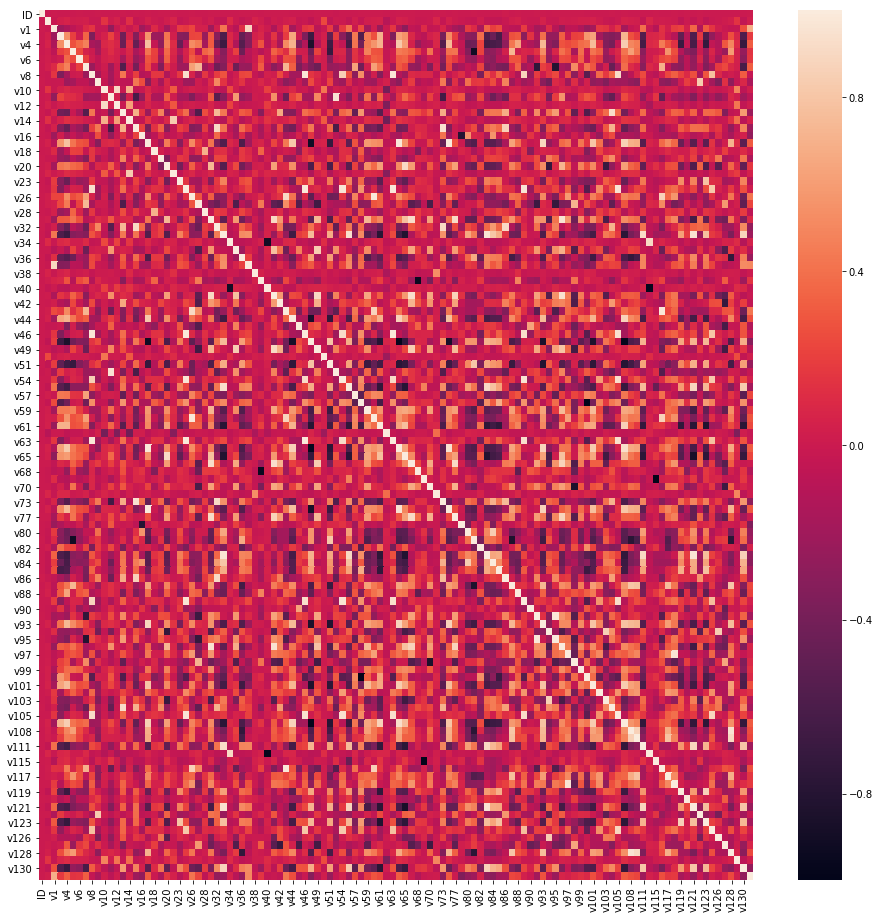

In [7]:
corrmat = train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(16,16)
sns.heatmap(corrmat)

### We can see that there are few variable with correlation >0.8

## Pre-processing

Pre processing of data to make it model ready

In [13]:
# checking data types of different variable
train.dtypes

ID          int64
target      int64
v1        float64
v2        float64
v3         object
           ...   
v127      float64
v128      float64
v129        int64
v130      float64
v131      float64
Length: 133, dtype: object

#### we can see there are some categorical which will require treatment

In [9]:
#checking null value
train.isnull().sum()

ID            0
target        0
v1        49832
v2        49796
v3         3457
          ...  
v127      49832
v128      48624
v129          0
v130      49843
v131      49895
Length: 133, dtype: int64

#### There are some variable with missing value . So we have to do  missing value imputation

In [15]:
for col in train.columns:
    if train[col].dtype=='object':
        train[col].fillna(train[col].mode()[0],inplace=True)

In [16]:
for col in train.columns:
    if train[col].dtype!='object':
        train[col].fillna(train[col].mean(),inplace=True)

### Taking care of categorical variable , doing label encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
le=LabelEncoder()

In [19]:
for col in train.columns:
    if train[col].dtype=='object':
        le.fit(train[col].values)
        train[col]=le.transform(train[col])

In [20]:
X=train.drop(['ID','target'],axis=1)
y=train[['target']]

## Analysis

Splitting data into 70:30 for train and validation

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,random_state=123)


Building a baseline model for the performance comparison

We are using AUC as a metric since in imbalanced problem AUC is the right metric to evaluate model performance

In [22]:
xgb_model=XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200,seed=123)
xgb_model.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],eval_metric=['auc'],verbose=50)

[0]	validation_0-auc:0.713973	validation_1-auc:0.711512
[50]	validation_0-auc:0.753105	validation_1-auc:0.745047
[100]	validation_0-auc:0.766433	validation_1-auc:0.749188
[150]	validation_0-auc:0.776875	validation_1-auc:0.750489
[199]	validation_0-auc:0.786068	validation_1-auc:0.751041


XGBClassifier(max_depth=4, n_estimators=200, seed=123)

#### Checking variable importance 

In [23]:
variable_imp=pd.DataFrame({'variable':X_train.columns,'imp':xgb_model.feature_importances_})
variable_imp.sort_values('imp',ascending=False,inplace=True)
variable_imp['percentile']=variable_imp['imp']*100/variable_imp.iloc[0,1]


In [24]:
variable_imp.head(10)

,variable,imp,percentile
30,v31,0.101652,100.000000
49,v50,0.094939,93.396133
46,v47,0.058589,57.637123
65,v66,0.042991,42.292385
128,v129,0.023260,22.881424
109,v110,0.019462,19.145634
37,v38,0.015187,14.939776
23,v24,0.013409,13.191084
39,v40,0.011778,11.586993
73,v74,0.010107,9.942458


In [25]:
variable_imp.tail(10)

,variable,imp,percentile
21,v22,0.003540,3.482805
59,v60,0.003288,3.234428
64,v65,0.003222,3.169968
22,v23,0.003156,3.105018
29,v30,0.003048,2.998159
51,v52,0.002883,2.836267
1,v2,0.002815,2.769019
74,v75,0.002552,2.510395
90,v91,0.002472,2.431778
2,v3,0.001738,1.709312


## Removing correlated variable

In [27]:
grouped_feature_ls = []
correlated_groups = []

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

removing variable with correlation > 0.9

In [28]:
corr_features = correlation(train, 0.9)

In [29]:
correlated_features = set(corr_features)

In [30]:
correlated_features

{'v100',
 'v104',
 'v105',
 'v106',
 'v111',
 'v114',
 'v115',
 'v116',
 'v118',
 'v12',
 'v121',
 'v128',
 'v25',
 'v32',
 'v40',
 'v41',
 'v43',
 'v46',
 'v48',
 'v49',
 'v53',
 'v54',
 'v55',
 'v60',
 'v63',
 'v64',
 'v65',
 'v67',
 'v68',
 'v73',
 'v75',
 'v76',
 'v77',
 'v81',
 'v83',
 'v86',
 'v89',
 'v95',
 'v96'}

In [31]:
print(len(correlated_features))

39


In [32]:
# Dropping all the correlated features from the data
X.drop(labels=correlated_features, axis=1, inplace=True)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,random_state=123)


#### Checking performance

In [35]:
xgb_model=XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200,seed=123)
xgb_model.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],eval_metric=['auc'],verbose=50)

[0]	validation_0-auc:0.714355	validation_1-auc:0.71274
[50]	validation_0-auc:0.751881	validation_1-auc:0.744253
[100]	validation_0-auc:0.765594	validation_1-auc:0.7486
[150]	validation_0-auc:0.776314	validation_1-auc:0.750478
[199]	validation_0-auc:0.784501	validation_1-auc:0.751112


XGBClassifier(max_depth=4, n_estimators=200, seed=123)

#### checking variable importance

In [36]:
variable_imp=pd.DataFrame({'variable':X_train.columns,'imp':xgb_model.feature_importances_})
variable_imp.sort_values('imp',ascending=False,inplace=True)
variable_imp['percentile']=variable_imp['imp']*100/variable_imp.iloc[0,1]


In [37]:
variable_imp.head(10)

,variable,imp,percentile
28,v31,0.128794,100.000000
40,v50,0.107907,83.782379
39,v47,0.075581,58.683376
49,v66,0.054763,42.519997
89,v129,0.023119,17.950085
77,v110,0.022735,17.651957
34,v38,0.022071,17.136862
22,v24,0.015412,11.966598
54,v74,0.012935,10.043496
56,v79,0.012564,9.755424


In [38]:
variable_imp.tail(10)

,variable,imp,percentile
86,v125,0.004914,3.815506
27,v30,0.004856,3.770383
65,v92,0.004850,3.765587
21,v23,0.004842,3.759513
78,v112,0.004777,3.709169
36,v42,0.004695,3.645041
42,v52,0.004189,3.252334
64,v91,0.003833,2.975994
74,v107,0.003396,2.636678
2,v3,0.001986,1.542317


#### We can see that there is marginal increase in performance, implying that xgboost is not heavily impacted by removal of the correlated variable.

## ****** Thanks ******